<a href="https://colab.research.google.com/github/rachidelfermi/DL_genesPrediction/blob/master/DL_genesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%time
import numpy as np
from scipy.io import loadmat
from numpy import array,argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from warnings import simplefilter
from keras.optimizers import SGD
import tensorflow as tf
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn import metrics
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
simplefilter(action='ignore', category=FutureWarning)

CPU times: user 1.67 s, sys: 303 ms, total: 1.97 s
Wall time: 7.38 s


In [4]:
%%time
annots = loadmat('drive/My Drive/TrainingPart2_131207.mat')

CPU times: user 23 s, sys: 2.61 s, total: 25.6 s
Wall time: 25.7 s


In [5]:
%%time
sequence=[]
label=[]
print("A =",ord("A"),"C =",ord("C"),"G =",ord("G"),"T =",ord("T"))
for i in range(0,200000,1):
    valid =(np.count_nonzero(annots['OrfSeqs'][i][0][0]==65, axis=0)>=1 and np.count_nonzero(annots['OrfSeqs'][i][0][0]==67, axis=0)>=1 
    and np.count_nonzero(annots['OrfSeqs'][i][0][0]==71, axis=0)>=1 and np.count_nonzero(annots['OrfSeqs'][i][0][0]==84, axis=0)>=1 )
    if valid == True :
        sequence.append(annots['OrfSeqs'][i][0][0])
        label.append(1 if annots['CandLabel'][i][0]==1 else 0)


A = 65 C = 67 G = 71 T = 84
CPU times: user 8.37 s, sys: 21.6 ms, total: 8.39 s
Wall time: 8.39 s


In [7]:
sequence[:3]

[array([65, 84, 71, 84, 71, 67, 84, 84, 71, 65, 65, 71, 67, 84, 71, 67, 84,
        67, 84, 71, 71, 67, 71, 84, 84, 67, 67, 67, 84, 67, 65, 67, 67, 67,
        84, 71, 65, 65, 84, 84, 84, 84, 71, 67, 67, 84, 84, 67, 67, 71, 67,
        84, 65, 67, 65, 65, 67, 65, 84, 65, 65, 65, 84, 65, 84, 65, 71, 84,
        67, 71, 71, 67, 65, 65, 84, 67, 71, 65, 67, 65, 65, 84, 71, 84, 84,
        84, 67, 65, 71, 67, 71, 65, 67, 65, 84, 67, 71, 84, 71, 84, 71, 65],
       dtype=uint8),
 array([84, 84, 71, 71, 67, 67, 65, 71, 67, 71, 65, 65, 65, 71, 71, 84, 84,
        67, 65, 84, 67, 65, 84, 65, 67, 65, 84, 65, 65, 84, 67, 65, 71, 65,
        84, 67, 65, 71, 71, 65, 84, 67, 67, 65, 71, 84, 71, 67, 65, 65, 84,
        65, 71, 67, 65, 67, 71, 67, 71, 67, 67, 65, 71, 65, 71, 67, 67, 65,
        67, 65, 67, 71, 65, 67, 71, 65, 84, 84, 67, 65, 84, 65, 67, 67, 65,
        67, 67, 65, 71, 65, 84, 65, 65], dtype=uint8),
 array([65, 84, 71, 67, 71, 67, 65, 67, 71, 65, 65, 84, 84, 71, 71, 71, 65,
        65,

In [13]:
orfLenght=[]
for orf in sequence:
  orfLenght.append(len(orf))
print(orfLenght[:30])

[102, 93, 102, 252, 162, 108, 90, 126, 81, 72, 582, 63, 63, 84, 132, 66, 186, 60, 69, 237, 87, 90, 177, 66, 72, 90, 84, 483, 66, 96]


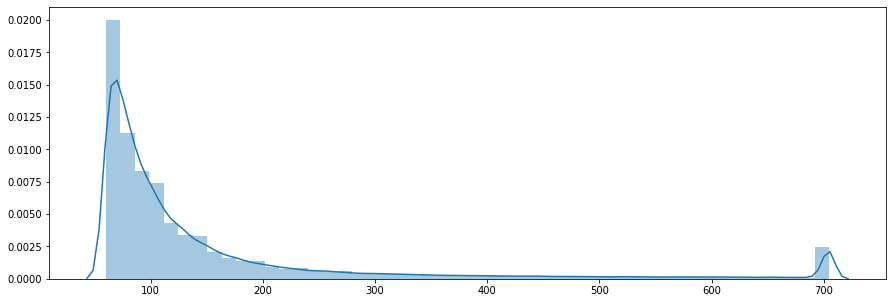

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
sns.distplot(orfLenght)
plt.show()

In [22]:
%%time

def onehote(seq):
    seq2=list()
    mapping = {65:[1., 0., 0., 0.], 67: [0., 1., 0., 0.], 71: [1., 0., 0., 0.], 84:[0., 0., 0., 1.]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0., 0., 0., 0.]) 
    return np.array(seq2)
oneHotEncoded=[]

for orf in sequence:
    oneHotEncoded.append(onehote(orf))
#printing the first 10 bases encoded of an orf
print(oneHotEncoded[0][:10])

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
CPU times: user 1min 49s, sys: 335 ms, total: 1min 49s
Wall time: 1min 49s


In [23]:
def padding(seq):
   return np.stack(tf.keras.preprocessing.sequence.pad_sequences(seq, padding="post"))
input_features = padding(oneHotEncoded)
#lenght of the ORFs now is Standardize to 705 the longest ORF
print(len(input_features[0]))

705


In [26]:
def encodeLabel(labels):
    one_hot_encoder = OneHotEncoder()
    labels = np.array(labels).reshape(-1, 1)
    labels = one_hot_encoder.fit_transform(labels).toarray()
    return labels
input_labels=encodeLabel(label)
#printing the first 10 encoded labels
print(input_labels[:10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [27]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [29]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=21, input_shape=(train_features.shape[1], 4), 
                padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=200, kernel_size=21, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

epochs = 50
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 705, 64)           5440      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 352, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 352, 200)          269000    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 176, 200)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 176, 200)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [31]:
history = model.fit(train_features, train_labels, 
                    epochs=epochs, verbose=2, validation_split=0.25, batch_size=256, shuffle=True)

Epoch 1/50
440/440 - 13s - loss: 0.0286 - binary_accuracy: 0.9898 - val_loss: 0.0814 - val_binary_accuracy: 0.9750
Epoch 2/50
440/440 - 13s - loss: 0.0274 - binary_accuracy: 0.9900 - val_loss: 0.0812 - val_binary_accuracy: 0.9752
Epoch 3/50
440/440 - 13s - loss: 0.0279 - binary_accuracy: 0.9900 - val_loss: 0.0798 - val_binary_accuracy: 0.9755
Epoch 4/50
440/440 - 13s - loss: 0.0268 - binary_accuracy: 0.9905 - val_loss: 0.0820 - val_binary_accuracy: 0.9750
Epoch 5/50
440/440 - 13s - loss: 0.0265 - binary_accuracy: 0.9906 - val_loss: 0.0811 - val_binary_accuracy: 0.9750
Epoch 6/50
440/440 - 13s - loss: 0.0258 - binary_accuracy: 0.9905 - val_loss: 0.0797 - val_binary_accuracy: 0.9755
Epoch 7/50
440/440 - 13s - loss: 0.0253 - binary_accuracy: 0.9911 - val_loss: 0.0857 - val_binary_accuracy: 0.9749
Epoch 8/50
440/440 - 13s - loss: 0.0254 - binary_accuracy: 0.9911 - val_loss: 0.0853 - val_binary_accuracy: 0.9749
Epoch 9/50
440/440 - 13s - loss: 0.0236 - binary_accuracy: 0.9917 - val_loss: 0.

In [34]:
predicted_labels = model.predict(np.stack(test_features))
scores = model.evaluate(test_features, test_labels, verbose=0)
confusion = metrics.confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))
TP = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]
FN = confusion[1, 0]
Recall=TP / float(TP + FN)
Precision=TP / float(TP + FP)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Sensitivity  ',Recall)
print('specificity ',Precision)
print('harmonic mean ',2*(Recall * Precision) / (Recall + Precision))



Accuracy: 97.73%
Sensitivity   0.8657152682255846
specificity  0.93396401409757
harmonic mean  0.8985455518872133
